In [1]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import signal
import IPython
import pickle

In [2]:
# reload the trained gaussian process classifier
gpc = pickle.load(open('gpc_trained.pkl','rb'))

One advantage of having a classifier that can output epistemic uncertainty about a prediction is that it can abstain from making certain predictions. If we add this ability to our model, we need a new way to evaluate it. We'll explore a few different ideas around this.

First, we'll start by comparing the accuracy of class probability outputs given different levels of uncertainty. To do this, we'll combine predictions from all the different datasets.

In [3]:
# Reload the datasets like in notebook 2
X_orig = pd.read_csv('X_orig_binary.csv')
Y_orig = pd.read_csv('Y_orig_binary.csv')
X_test = pd.read_csv('X_test_binary.csv')
Y_test = pd.read_csv('Y_test_binary.csv')
X_white_noise = pd.read_csv('X_white_noise_binary.csv')
Y_white_noise = pd.read_csv('Y_white_noise_binary.csv')
X_motion_blur = pd.read_csv('X_motion_blur_binary.csv')
Y_motion_blur = pd.read_csv('Y_motion_blur_binary.csv')
X_reduced_contrast = pd.read_csv('X_reduced_contrast_binary.csv')
Y_reduced_contrast = pd.read_csv('Y_reduced_contrast_binary.csv')
X_fgm10 = pd.read_csv('X_fgm_10_binary.csv')
Y_fgm10 = pd.read_csv('Y_fgm_10_binary.csv')
X_fgm25 = pd.read_csv('X_fgm_25_binary.csv')
Y_fgm25 = pd.read_csv('Y_fgm_25_binary.csv')
X_fgm50 = pd.read_csv('X_fgm_50_binary.csv')
Y_fgm50 = pd.read_csv('Y_fgm_50_binary.csv')
X_fgm100 = pd.read_csv('X_fgm_100_binary.csv')
Y_fgm100 = pd.read_csv('Y_fgm_100_binary.csv')
X_pgd10 = pd.read_csv('X_pgd_10_binary.csv')
Y_pgd10 = pd.read_csv('Y_pgd_10_binary.csv')
X_pgd25 = pd.read_csv('X_pgd_25_binary.csv')
Y_pgd25 = pd.read_csv('Y_pgd_25_binary.csv')
X_pgd50 = pd.read_csv('X_pgd_50_binary.csv')
Y_pgd50 = pd.read_csv('Y_pgd_50_binary.csv')
X_pgd100 = pd.read_csv('X_pgd_100_binary.csv')
Y_pgd100 = pd.read_csv('Y_pgd_100_binary.csv')

del X_orig['Unnamed: 0']
del Y_orig['Unnamed: 0']
del Y_test['Unnamed: 0']
del X_test['Unnamed: 0']
del X_white_noise['Unnamed: 0']
del Y_white_noise['Unnamed: 0']
del X_motion_blur['Unnamed: 0']
del Y_motion_blur['Unnamed: 0']
del X_reduced_contrast['Unnamed: 0']
del Y_reduced_contrast['Unnamed: 0']
del X_fgm10['Unnamed: 0']
del Y_fgm10['Unnamed: 0']
del X_fgm25['Unnamed: 0']
del Y_fgm25['Unnamed: 0']
del X_fgm50['Unnamed: 0']
del Y_fgm50['Unnamed: 0']
del X_fgm100['Unnamed: 0']
del Y_fgm100['Unnamed: 0']
del X_pgd10['Unnamed: 0']
del Y_pgd10['Unnamed: 0']
del X_pgd25['Unnamed: 0']
del Y_pgd25['Unnamed: 0']
del X_pgd50['Unnamed: 0']
del Y_pgd50['Unnamed: 0']
del X_pgd100['Unnamed: 0']
del Y_pgd100['Unnamed: 0']


In [4]:
# convert the dataframes to np arrays for easier processing
X_orig = X_orig.to_numpy()
Y_orig = Y_orig.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
X_white_noise = X_white_noise.to_numpy()
Y_white_noise = Y_white_noise.to_numpy()
X_motion_blur = X_motion_blur.to_numpy()
Y_motion_blur = Y_motion_blur.to_numpy()
X_reduced_contrast = X_reduced_contrast.to_numpy()
Y_reduced_contrast = Y_reduced_contrast.to_numpy()
X_fgm10 = X_fgm10.to_numpy()
Y_fgm10 = Y_fgm10.to_numpy()
X_fgm25 = X_fgm25.to_numpy()
Y_fgm25 = Y_fgm25.to_numpy()
X_fgm50 = X_fgm50.to_numpy()
Y_fgm50 = Y_fgm50.to_numpy()
X_fgm100 = X_fgm100.to_numpy()
Y_fgm100 = Y_fgm100.to_numpy()
X_pgd10 = X_pgd10.to_numpy()
Y_pgd10 = Y_pgd10.to_numpy()
X_pgd25 = X_pgd25.to_numpy()
Y_pgd25 = Y_pgd25.to_numpy()
X_pgd50 = X_pgd50.to_numpy()
Y_pgd50 = Y_pgd50.to_numpy()
X_pgd100 = X_pgd100.to_numpy()
Y_pgd100 = Y_pgd100.to_numpy()

In [87]:
# Then, gather predictions over all the datasets:
u_orig = []
u_test = []
u_white_noise = []
u_motion_blur = []
u_reduced_contrast = []
u_fgm10 = []
u_fgm25 = []
u_fgm50 = []
u_fgm100 = []
u_pgd10 = []
u_pgd25 = []
u_pgd50 = []
u_pgd100 = []
X_orig_preds = gpc.predict_proba(X_orig, uncertainty = u_orig)
X_test_preds = gpc.predict_proba(X_test, uncertainty= u_test)
X_white_noise_preds = gpc.predict_proba(X_white_noise, uncertainty = u_white_noise)
X_motion_blur_preds = gpc.predict_proba(X_motion_blur, uncertainty = u_motion_blur)
X_reduced_contrast_preds = gpc.predict_proba(X_reduced_contrast, uncertainty = u_reduced_contrast)
X_fgm10_preds = gpc.predict_proba(X_fgm10, uncertainty = u_fgm10)
X_fgm25_preds = gpc.predict_proba(X_fgm25, uncertainty = u_fgm25)
X_fgm50_preds = gpc.predict_proba(X_fgm50, uncertainty = u_fgm50)
X_fgm100_preds = gpc.predict_proba(X_fgm100, uncertainty = u_fgm100)
X_pgd10_preds = gpc.predict_proba(X_pgd10, uncertainty = u_pgd10)
X_pgd25_preds = gpc.predict_proba(X_pgd25, uncertainty = u_pgd25)
X_pgd50_preds = gpc.predict_proba(X_pgd50, uncertainty = u_pgd50)
X_pgd100_preds = gpc.predict_proba(X_pgd100, uncertainty = u_pgd100)
u_orig = np.array(u_orig)
u_white_noise = np.array(u_white_noise)
u_motion_blur = np.array(u_motion_blur)
u_reduced_contrast = np.array(u_reduced_contrast)
u_fgm10 = np.array(u_fgm10)
u_fgm25 = np.array(u_fgm25)
u_fgm50 = np.array(u_fgm50)
u_fgm100 = np.array(u_fgm100)
u_pgd10 = np.array(u_pgd10)
u_pgd25 = np.array(u_pgd25)
u_pgd50 = np.array(u_pgd50)
u_pgd100 = np.array(u_pgd100)

In [88]:
unaltered_preds = [X_orig_preds, X_test_preds]
unaltered_uncertainties = [u_orig, u_test]
unaltered_true = [Y_orig, Y_test]

noisy_preds = [X_white_noise_preds,X_motion_blur_preds, X_reduced_contrast_preds]
noisy_uncertainties = [u_white_noise,u_motion_blur,u_reduced_contrast]
noisy_true = [Y_white_noise,Y_motion_blur,Y_reduced_contrast]

adv_preds =[X_pgd10_preds,X_pgd25_preds,X_pgd50_preds,X_pgd100_preds,X_fgm10_preds,X_fgm25_preds,X_fgm50_preds,X_fgm100_preds]
adv_uncertainties = [u_pgd10,u_pgd25,u_pgd50,u_pgd100,u_fgm10,u_fgm25,u_fgm50,u_fgm100]
adv_true = [Y_pgd10,Y_pgd25,Y_pgd50,Y_pgd100,Y_fgm10,Y_fgm25,Y_fgm50,Y_fgm100]

df_orig = pd.DataFrame(np.concatenate(unaltered_preds))
df_orig['uncertainty'] = np.concatenate(unaltered_uncertainties,axis=1).reshape(-1,1)
df_orig['true'] = np.concatenate(unaltered_true)
df_orig['pred'] = 0
df_orig['pred'].loc[df_orig[1] >.5] = 1
df_orig['correct'] = df_orig['true'] == df_orig['pred']
df_orig['confidence'] = pd.concat([df_orig[0], df_orig[1]], axis=1).max(axis=1)

df_noisy = pd.DataFrame(np.concatenate(noisy_preds))
df_noisy['uncertainty'] = np.concatenate(noisy_uncertainties,axis=1).reshape(-1,1)
df_noisy['true'] = np.concatenate(noisy_true)
df_noisy['pred'] = 0
df_noisy['pred'].loc[df_noisy[1] >.5] = 1
df_noisy['correct'] = df_noisy['true'] == df_noisy['pred']
df_noisy['confidence'] = pd.concat([df_noisy[0], df_noisy[1]], axis=1).max(axis=1)

df_adv = pd.DataFrame(np.concatenate(adv_preds))
df_adv['uncertainty'] = np.concatenate(adv_uncertainties,axis=1).reshape(-1,1)
df_adv['true'] = np.concatenate(adv_true)
df_adv['pred'] = 0
df_adv['pred'].loc[df_adv[1] >.5] = 1
df_adv['correct'] = df_adv['true'] == df_adv['pred']
df_adv['confidence'] = pd.concat([df_adv[0], df_adv[1]], axis=1).max(axis=1)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1
(0.0, 0.1]    14720
(0.1, 0.2]       42
(0.2, 0.3]       13
(0.3, 0.4]        3
(0.4, 0.5]        2
(0.5, 0.6]        2
(0.6, 0.7]        3
(0.7, 0.8]       13
(0.8, 0.9]       42
(0.9, 1.0]    14720
Name: count, dtype: int64
ECE: 0.10104194857916106


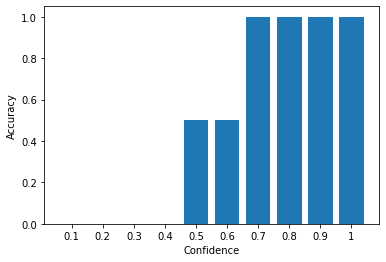

In [138]:
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
df_orig['count'] = 1
grouped0 = df_orig.copy().groupby(pd.cut(df_orig[0], bins)).sum()
grouped1 = df_orig.copy().groupby(pd.cut(df_orig[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])
acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('unaltered_calibration.png',dpi=400)

ECE: 0.24555073035925776


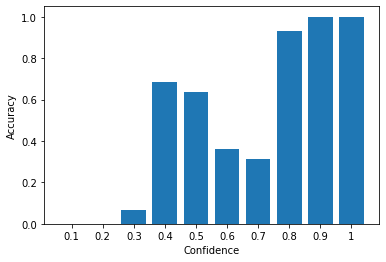

In [137]:
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
df_noisy['count'] = 1
grouped0 = df_noisy.copy().groupby(pd.cut(df_noisy[0], bins)).sum()
grouped1 = df_noisy.copy().groupby(pd.cut(df_noisy[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('noisy_calibration.png',dpi=400)

1
(0.0, 0.1]    12148
(0.1, 0.2]     4702
(0.2, 0.3]     3286
(0.3, 0.4]     3683
(0.4, 0.5]     9846
(0.5, 0.6]     9846
(0.6, 0.7]     3683
(0.7, 0.8]     3286
(0.8, 0.9]     4702
(0.9, 1.0]    12148
Name: count, dtype: int64
ECE: 0.09075003713055102


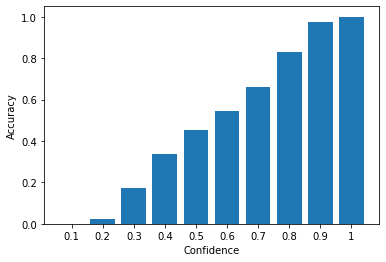

In [136]:
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
df_adv['count'] = 1
grouped0 = df_adv.copy().groupby(pd.cut(df_adv[0], bins)).sum()
grouped1 = df_adv.copy().groupby(pd.cut(df_adv[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])
acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('adversarial_calibration.png',dpi=400)

In [102]:
# Then, join all of them in a dataframe

all_preds = [X_orig_preds,X_white_noise_preds,X_motion_blur_preds,
X_reduced_contrast_preds, X_pgd10_preds,X_pgd25_preds,X_pgd50_preds,X_pgd100_preds,X_fgm10_preds,X_fgm25_preds,X_fgm50_preds,X_fgm100_preds]
all_uncertainties = [u_orig,u_white_noise,u_motion_blur,u_reduced_contrast, u_pgd10,u_pgd25,u_pgd50,u_pgd100,u_fgm10,u_fgm25,u_fgm50,u_fgm100]
all_true = [Y_orig, Y_white_noise,Y_motion_blur,
Y_reduced_contrast, Y_pgd10,Y_pgd25,Y_pgd50,Y_pgd100,Y_fgm10,Y_fgm25,Y_fgm50,Y_fgm100]


df = pd.DataFrame(np.concatenate(all_preds))
df['uncertainty'] = np.concatenate(all_uncertainties,axis=1).reshape(-1,1)
df['true'] = np.concatenate(all_true)
df['pred'] = 0
df['pred'].loc[df[1] >.5] = 1
df['correct'] = df['true'] == df['pred']
df['confidence'] = pd.concat([df[0], df[1]], axis=1).max(axis=1)

# dfa = pd.DataFrame(np.concatenate(adv_preds))
# dfa['uncertainty'] = np.concatenate(adv_uncertainties,axis=1).reshape(-1,1)
# dfa['true'] = np.concatenate(adv_true)
# dfa['pred'] = 0
# dfa['pred'].loc[dfa[1] >.5] = 1
# dfa['correct'] = dfa['true'] == dfa['pred']
# dfa['confidence'] = pd.concat([dfa[0], dfa[1]], axis=1).max(axis=1)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now that we have this data, we want to plot graphs of the accuracy of probabilities at different uncertainty levels.

1
(0.0, 0.1]    8029
(0.1, 0.2]       0
(0.2, 0.3]       0
(0.3, 0.4]       0
(0.4, 0.5]       0
(0.5, 0.6]       0
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]    8029
Name: count, dtype: int64
ECE: nan


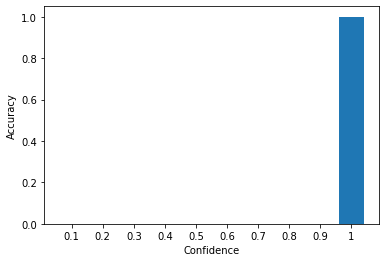

In [135]:
# plotting probabilities that the result is a 1
low = 0
high = .2
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t['count'] = 1
grouped0 = t.copy().groupby(pd.cut(t[0], bins)).sum()
grouped1 = t.copy().groupby(pd.cut(t[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])

acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('all_calibration2.png',dpi=400)

1
(0.0, 0.1]    30509
(0.1, 0.2]     9222
(0.2, 0.3]     2405
(0.3, 0.4]     2229
(0.4, 0.5]     3391
(0.5, 0.6]     3391
(0.6, 0.7]     2229
(0.7, 0.8]     2405
(0.8, 0.9]     9222
(0.9, 1.0]    30509
Name: count, dtype: int64
ECE: 0.17676941117346517


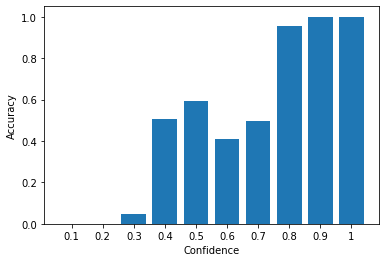

In [134]:
low = .2
high = .4
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t['count'] = 1
grouped0 = t.copy().groupby(pd.cut(t[0], bins)).sum()
grouped1 = t.copy().groupby(pd.cut(t[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])

acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('all_calibration4.png',dpi=400)


1
(0.0, 0.1]    3670
(0.1, 0.2]    4548
(0.2, 0.3]    3323
(0.3, 0.4]    2309
(0.4, 0.5]    1829
(0.5, 0.6]    1829
(0.6, 0.7]    2309
(0.7, 0.8]    3323
(0.8, 0.9]    4548
(0.9, 1.0]    3670
Name: count, dtype: int64
ECE: 0.24813444734995857


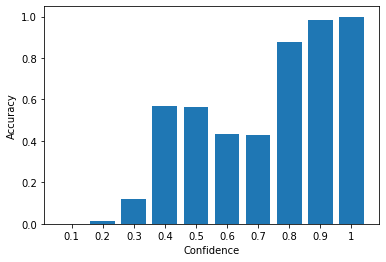

In [133]:
low = .4
high = .6
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t['count'] = 1
grouped0 = t.copy().groupby(pd.cut(t[0], bins)).sum()
grouped1 = t.copy().groupby(pd.cut(t[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])

acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('all_calibration6.png',dpi=400)


In [78]:
low = .4
high = .5
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t.loc[(t['confidence']>0.5) & (t['confidence']<=0.6) & (t['true']==1)]

,0,1,uncertainty,true,pred,correct,confidence


1
(0.0, 0.1]    673
(0.1, 0.2]    672
(0.2, 0.3]    644
(0.3, 0.4]    838
(0.4, 0.5]    881
(0.5, 0.6]    881
(0.6, 0.7]    838
(0.7, 0.8]    644
(0.8, 0.9]    672
(0.9, 1.0]    673
Name: count, dtype: int64
ECE: 0.08883495145631068


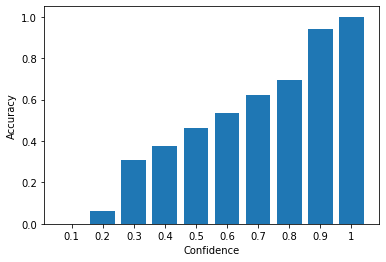

In [132]:
low = .6
high = .8
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t['count'] = 1
grouped0 = t.copy().groupby(pd.cut(t[0], bins)).sum()
grouped1 = t.copy().groupby(pd.cut(t[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])

acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('all_calibration8.png',dpi=400)

1
(0.0, 0.1]      11
(0.1, 0.2]     197
(0.2, 0.3]     484
(0.3, 0.4]    1129
(0.4, 0.5]    7332
(0.5, 0.6]    7332
(0.6, 0.7]    1129
(0.7, 0.8]     484
(0.8, 0.9]     197
(0.9, 1.0]      11
Name: count, dtype: int64
ECE: 0.020441385338140515


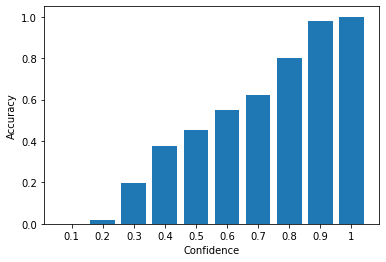

In [131]:
low = .8
high = 1.1
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
t = df.loc[(df['uncertainty']>low) & (df['uncertainty']<=high)].copy()
t['count'] = 1
grouped0 = t.copy().groupby(pd.cut(t[0], bins)).sum()
grouped1 = t.copy().groupby(pd.cut(t[1], bins)).sum()
total_correct = grouped1['true'] + (grouped0['count'] - grouped0['true'])
plt.bar(np.arange(1,11), total_correct/(grouped1['count'] + grouped0['count']))
plt.xticks(np.arange(1,11), [str(bins[i+1]) for i in range(10)])
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
print(grouped1['count'] + grouped0['count'])

acc = total_correct/(grouped1['count'] + grouped0['count'])
conf = [(bins[i] + bins[i+1]) / 2 for i in range(10)]
n = sum(grouped0['count'])
counts = grouped1['count'] + grouped0['count']
ece = sum(counts / n * np.abs(acc - conf))
print(f"ECE: {ece}")
plt.savefig('all_calibration11.png',dpi=400)

So far from this, it seems like high uncertainty doesn't have a huge effect on how good the trend is.  Uncertainty between .5 and .6 looks the best, maybe too little data on the really low end but high end still isn't too bad.

Next, we want to look at how this model could be scored if it is able to "abstain" from making a prediction. F1 may not be good because that looks at the outputs, not the epistemic uncertainty. Why would you abstain based on epistemic then? Unless there were a big dropoff somewhere e.g. .6 prob and high uncertainty actually meant less than .6 probs

Also, by law of large numbers everything should do equally well. It makes sense that anything with super low uncertainty will be pretty confident as well-- it's not like there can actually be a 50/50 chance that something is a 0 or a 1. Also, I can't think of a situation when it really makes sense to abstain based on epistemic uncertainty. Even if uncertainty is high but confidence is also high, it's still pretty likely that the result will be the same as the prediction.

# Loss
As another evaluation metric, we should consider how to evaluate a model that can abstain from making predictions as well. If we consider a situation where it is worse to make an incorrect prediction than it is to avoid making a prediction at all, then maybe we can take advantage of our knowledge of the epistemic uncertainty at a given point as well as the confidence score given by our model.

Confidence alone may not be enough because it is well known that many models, including neural networks, are not generally well calibrated to calculate true probabilities. 

We'll define a loss function where we lose 1 point for abstaining from a prediction, and 2 points for an incorrect prediction. Then, we can explore if the extra information about epistemic uncertainty helps us improve.

In [59]:
# first, we look at what happens when we don't take into account epistemic uncertainty
def loss(gpc, x, y):
    preds = gpc.predict_proba(x)
    loss = 0
    for i,a in enumerate(preds):
        conf = max(a)
        if conf > 2/3:
            if np.argmax(a) != y[i]:
                loss += 2
        else:
            loss += 1
    return loss

In [63]:
loss(gpc, X_test, Y_test)

0

In [64]:
loss(gpc, X_reduced_contrast, Y_reduced_contrast)

6414

In [65]:
loss(gpc, X_pgd100, Y_pgd100)

1500

In [66]:
# how do I learn the curve between confidence cutoff and uncertainty ? But that's basically what I need to do to see if there's something better with this 

1500